In [39]:
#!/usr/bin/env python3
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
import collections

In [42]:
# ------------------------------------------------
# ENVIRONMENT: 3D Sculpting with a Router
# ------------------------------------------------
class Sculpt3DEnv:
    def __init__(self, grid_size=8, max_steps=10, manager_update_freq=5):
        """
        3D sculpt environment:
         - NxNxN 'stock' array (True => material present)
         - NxNxN 'shape' array (True => protected shape)
         - A router at (0,0,0).
         - Manager picks subgoals in [0..N^3 -1].
         - Worker picks 6 discrete steps: ±x, ±y, ±z.
        """
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.manager_update_freq = manager_update_freq
        self.reset()

    def reset(self):
        # Initialize stock to True (material present)
        self.stock = np.ones((self.grid_size, self.grid_size, self.grid_size), dtype=bool)
        
        # Create shape (True => shape). Use a bigger radius so it's clearly visible
        self.shape = np.zeros((self.grid_size, self.grid_size, self.grid_size), dtype=bool)
        cx, cy, cz = self.grid_size//2, self.grid_size//2, self.grid_size//2
        # Make shape large so we definitely see it
        r = self.grid_size // 2 - 1 
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                for z in range(self.grid_size):
                    dx, dy, dz = x-cx, y-cy, z-cz
                    dist = dx*dx + dy*dy + dz*dz
                    if dist <= r*r:
                        self.shape[x,y,z] = True
        
        self.router_pos = np.array([0,0,0], dtype=int)
        self.steps_taken = 0
        self.done = False
        
        # Manager subgoal
        self.subgoal = np.array([cx,cy,cz], dtype=int)

        print("shape voxels =", np.sum(self.shape))

        return self._get_manager_obs(), self._get_worker_obs()

    def set_subgoal(self, coord):
        coord = np.clip(coord, 0, self.grid_size-1)
        self.subgoal = coord

    def worker_step(self, action):
        """
        action in [0..5]: 0=+x,1=-x,2=+y,3=-y,4=+z,5=-z
        If shape is cut or OOB => done with penalty.
        If outside stock is removed => small reward.
        """
        if self.done:
            return self._get_worker_obs(), 0.0, True
        move = np.array([0,0,0], dtype=int)
        if action==0: move = np.array([1,0,0])
        elif action==1: move = np.array([-1,0,0])
        elif action==2: move = np.array([0,1,0])
        elif action==3: move = np.array([0,-1,0])
        elif action==4: move = np.array([0,0,1])
        elif action==5: move = np.array([0,0,-1])

        oldp = self.router_pos.copy()
        newp = oldp+move
        reward = 0.0
        # check OOB
        if not np.all((newp>=0)&(newp<self.grid_size)):
            reward -= 5.0
            self.done=True
        else:
            path = [oldp, newp]
            for (vx,vy,vz) in path:
                if self.shape[vx,vy,vz]:
                    # shape => penalty
                    reward -= 5.0
                    self.done=True
                    break
                if self.stock[vx,vy,vz]:
                    self.stock[vx,vy,vz] = False
                    reward += 1.0
            if not self.done:
                self.router_pos = newp

        self.steps_taken+=1
        if self.steps_taken>=self.max_steps:
            self.done=True

        return self._get_worker_obs(), reward, self.done

    def manager_reward(self):
        """
        fraction_outside_removed
        difference-based approach
        """
        outside_mask = (self.shape==False)
        outside_total = np.sum(outside_mask)
        outside_removed = outside_total - np.sum(self.stock[outside_mask])
        frac_removed = outside_removed/(outside_total+1e-8)
        return frac_removed

    def manager_done(self):
        return self.done

    def _get_manager_obs(self):
        outside_mask = (self.shape==False)
        outside_total = np.sum(outside_mask)
        outside_removed = outside_total - np.sum(self.stock[outside_mask])
        frac_removed = outside_removed/(outside_total+1e-8)
        rx,ry,rz = self.router_pos
        return np.array([frac_removed, rx, ry, rz], dtype=float)

    def _get_worker_obs(self):
        rx,ry,rz = self.router_pos
        sx,sy,sz = self.subgoal
        return np.array([rx,ry,rz, sx,sy,sz], dtype=float)
    
    def render(self, mode='human'):
        """
        Render the environment.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
        ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
        ax.scatter(*self.router_pos, color='yellow', s=100)
        ax.scatter(*self.subgoal, color='green', s=100)
        plt.show()
        plt.close(fig)
        return self.router_pos, self.subgoal

    def record_moves(self, moves):
        """
        Record the moves made by the router.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
        ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
        for move in moves:
            ax.scatter(*move, color='yellow', s=100)
        plt.show()
        plt.close(fig)
        
        # Save the recorded moves as a GIF
        images = []
        for move in moves:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
            ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
            ax.scatter(*move, color='yellow', s=100)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig('temp.png')
            images.append(imageio.imread('temp.png'))
            plt.close(fig)
        imageio.mimsave('router_moves.gif', images, fps=10)
        # Clean up temporary files
        for image in images:
            os.remove(image)
        return moves

    def close(self):
        """
        Close the environment.
        """
        pass

shape voxels = 3071
shape voxels = 3071
Initial observation: (array([0., 0., 0., 0.]), array([ 0.,  0.,  0., 10., 10., 10.]))
Step 0: Action 5, Observation [ 0.  0.  0. 10. 10. 10.], Reward -5.0, Done True


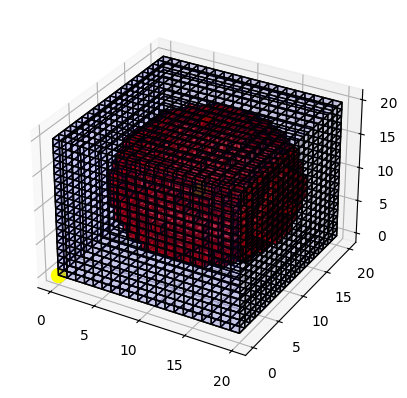

shape voxels = 3071
Action 5, Observation [ 0.  0.  0. 10. 10. 10.], Reward -5.0, Done True


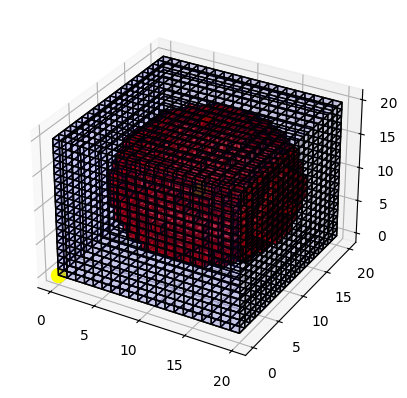

shape voxels = 3071
Action 3, Observation [ 0.  0.  0. 10. 10. 10.], Reward -5.0, Done True


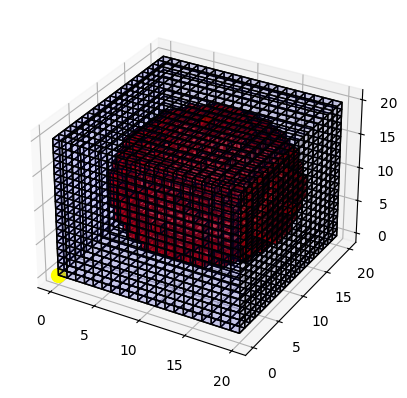

KeyboardInterrupt: 

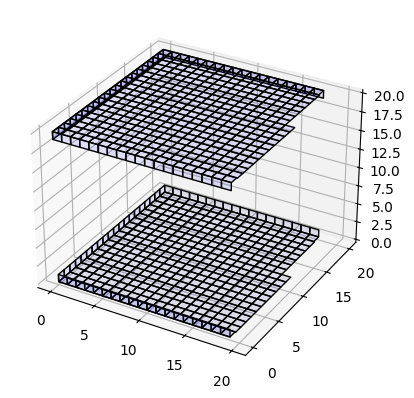

In [43]:
# ------------------------------------------------
# TEST ENVIRONMENT: 3D Sculpting with a Router
# ------------------------------------------------
def test_env():
    env = Sculpt3DEnv(grid_size=20)
    obs = env.reset()
    print("Initial observation:", obs)
    
    for step in range(10):
        action = random.randint(0, 5)
        obs, reward, done = env.worker_step(action)
        print(f"Step {step}: Action {action}, Observation {obs}, Reward {reward}, Done {done}")
        if done:
            break
    
    env.render()
    env.close()

def random_moves(env, num_moves=10):
    """
    Perform random moves in the environment.
    """
    for _ in range(num_moves):
        action = random.randint(0, 5)
        obs, reward, done = env.worker_step(action)
        print(f"Action {action}, Observation {obs}, Reward {reward}, Done {done}")
        if done:
            break
    env.render()
    env.close() 
    
try:
    test_env()
except Exception as e:
    print("Error during environment test:", e)

try:
    random_moves(Sculpt3DEnv(grid_size=20), num_moves=10)
except Exception as e:
    print("Error during random moves:", e)

try:
    env = Sculpt3DEnv(grid_size=20)
    moves = []
    for _ in range(10):
        action = random.randint(0, 5)
        obs, reward, done = env.worker_step(action)
        moves.append(env.router_pos.copy())
        print(f"Action {action}, Observation {obs}, Reward {reward}, Done {done}")
        if done:
            break
    env.record_moves(moves)
    env.close()
except Exception as e:
    print("Error during move recording:", e)

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import collections
import random
import imageio
from mpl_toolkits.mplot3d import Axes3D

# Define the environment (based on provided code)
class Sculpt3DEnv:
    def __init__(self, grid_size=20, max_steps=10, manager_update_freq=5):
        """
        3D sculpt environment:
         - NxNxN 'stock' array (True => material present)
         - NxNxN 'shape' array (True => protected shape)
         - A router at (0,0,0).
         - Manager picks subgoals in [0..N^3 -1].
         - Worker picks 6 discrete steps: ±x, ±y, ±z.
        """
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.manager_update_freq = manager_update_freq
        self.reset()

    def reset(self):
        # Initialize stock to True (material present)
        self.stock = np.ones((self.grid_size, self.grid_size, self.grid_size), dtype=bool)
        
        # Create shape (True => shape). Use a bigger radius so it's clearly visible
        self.shape = np.zeros((self.grid_size, self.grid_size, self.grid_size), dtype=bool)
        cx, cy, cz = self.grid_size//2, self.grid_size//2, self.grid_size//2
        # Make shape large so we definitely see it
        r = self.grid_size // 2 - 1 
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                for z in range(self.grid_size):
                    dx, dy, dz = x-cx, y-cy, z-cz
                    dist = dx*dx + dy*dy + dz*dz
                    if dist <= r*r:
                        self.shape[x,y,z] = True
        
        self.router_pos = np.array([0,0,0], dtype=int)
        self.steps_taken = 0
        self.done = False
        
        # Manager subgoal
        self.subgoal = np.array([cx,cy,cz], dtype=int)

        print("shape voxels =", np.sum(self.shape))

        return self._get_manager_obs(), self._get_worker_obs()

    def set_subgoal(self, coord):
        coord = np.clip(coord, 0, self.grid_size-1)
        self.subgoal = coord

    def worker_step(self, action):
        """
        action in [0..5]: 0=+x,1=-x,2=+y,3=-y,4=+z,5=-z
        If shape is cut or OOB => done with penalty.
        If outside stock is removed => small reward.
        """
        if self.done:
            return self._get_worker_obs(), 0.0, True
        move = np.array([0,0,0], dtype=int)
        if action==0: move = np.array([1,0,0])
        elif action==1: move = np.array([-1,0,0])
        elif action==2: move = np.array([0,1,0])
        elif action==3: move = np.array([0,-1,0])
        elif action==4: move = np.array([0,0,1])
        elif action==5: move = np.array([0,0,-1])

        oldp = self.router_pos.copy()
        newp = oldp+move
        reward = 0.0
        # check OOB
        if not np.all((newp>=0)&(newp<self.grid_size)):
            reward -= 5.0
            self.done=True
        else:
            path = [oldp, newp]
            for (vx,vy,vz) in path:
                if self.shape[vx,vy,vz]:
                    # shape => penalty
                    reward -= 5.0
                    self.done=True
                    break
                if self.stock[vx,vy,vz]:
                    self.stock[vx,vy,vz] = False
                    reward += 1.0
            if not self.done:
                self.router_pos = newp

        self.steps_taken+=1
        if self.steps_taken>=self.max_steps:
            self.done=True

        return self._get_worker_obs(), reward, self.done

    def manager_reward(self):
        """
        fraction_outside_removed
        difference-based approach
        """
        outside_mask = (self.shape==False)
        outside_total = np.sum(outside_mask)
        outside_removed = outside_total - np.sum(self.stock[outside_mask])
        frac_removed = outside_removed/(outside_total+1e-8)
        return frac_removed

    def manager_done(self):
        return self.done

    def _get_manager_obs(self):
        outside_mask = (self.shape==False)
        outside_total = np.sum(outside_mask)
        outside_removed = outside_total - np.sum(self.stock[outside_mask])
        frac_removed = outside_removed/(outside_total+1e-8)
        rx,ry,rz = self.router_pos
        return np.array([frac_removed, rx, ry, rz], dtype=float)

    def _get_worker_obs(self):
        rx,ry,rz = self.router_pos
        sx,sy,sz = self.subgoal
        return np.array([rx,ry,rz, sx,sy,sz], dtype=float)
    
    def render(self, mode='human'):
        """
        Render the environment.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
        ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
        ax.scatter(*self.router_pos, color='yellow', s=100)
        ax.scatter(*self.subgoal, color='green', s=100)
        plt.show()
        plt.close(fig)
        return self.router_pos, self.subgoal

    def record_moves(self, moves):
        """
        Record the moves made by the router.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
        ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
        for move in moves:
            ax.scatter(*move, color='yellow', s=100)
        plt.show()
        plt.close(fig)
        
        # Save the recorded moves as a GIF
        images = []
        for move in moves:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
            ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
            ax.scatter(*move, color='yellow', s=100)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig('temp.png')
            images.append(imageio.imread('temp.png'))
            plt.close(fig)
        imageio.mimsave('router_moves.gif', images, fps=10)
        # Clean up temporary files
        os.remove('temp.png')
        return moves

    def close(self):
        """
        Close the environment.
        """
        pass

# Experience replay buffer for DQN
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    
    def __len__(self):
        return len(self.buffer)

# Manager DQN - sets subgoals for worker
class ManagerAgent:
    def __init__(self, state_dim, action_dim, grid_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.grid_size = grid_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory = ReplayBuffer(10000)
        
        # Q-Network for predicting subgoal coordinates
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        # Neural network to estimate Q-values for subgoal coordinates
        inputs = Input(shape=(self.state_dim,))
        x = Dense(128, activation='relu')(inputs)
        x = Dense(128, activation='relu')(x)
        
        # Separate output heads for x, y, z coordinates
        x_coord = Dense(self.grid_size, activation='linear')(x)
        y_coord = Dense(self.grid_size, activation='linear')(x)
        z_coord = Dense(self.grid_size, activation='linear')(x)
        
        model = Model(inputs=inputs, outputs=[x_coord, y_coord, z_coord])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Random subgoal
            return np.random.randint(0, self.grid_size, size=3)
        
        # Predict best subgoal
        x_q, y_q, z_q = self.model.predict(np.array([state]), verbose=0)
        x = np.argmax(x_q[0])
        y = np.argmax(y_q[0])
        z = np.argmax(z_q[0])
        return np.array([x, y, z])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Get target Q-values
        x_target, y_target, z_target = self.target_model.predict(next_states, verbose=0)
        
        # Current Q-values
        x_curr, y_curr, z_curr = self.model.predict(states, verbose=0)
        
        for i in range(self.batch_size):
            if dones[i]:
                x_curr[i, actions[i][0]] = rewards[i]
                y_curr[i, actions[i][1]] = rewards[i]
                z_curr[i, actions[i][2]] = rewards[i]
            else:
                x_curr[i, actions[i][0]] = rewards[i] + self.gamma * np.max(x_target[i])
                y_curr[i, actions[i][1]] = rewards[i] + self.gamma * np.max(y_target[i])
                z_curr[i, actions[i][2]] = rewards[i] + self.gamma * np.max(z_target[i])
        
        self.model.fit(states, [x_curr, y_curr, z_curr], epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Worker DQN - executes low-level actions
class WorkerAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory = ReplayBuffer(10000)
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_dim, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_dim)
        
        act_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(act_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        targets = rewards + self.gamma * np.max(self.target_model.predict(next_states, verbose=0), axis=1) * (1 - dones)
        target_f = self.model.predict(states, verbose=0)
        
        for i in range(self.batch_size):
            target_f[i, actions[i]] = targets[i]
        
        self.model.fit(states, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Hierarchical RL training function
def train_hierarchical_agent(grid_size=8, episodes=1000, manager_update_freq=5, render_every=100):
    env = Sculpt3DEnv(grid_size=grid_size, manager_update_freq=manager_update_freq)
    
    manager = ManagerAgent(state_dim=4, action_dim=3, grid_size=grid_size)
    worker = WorkerAgent(state_dim=6, action_dim=6)
    
    best_reward = -float('inf')
    
    for e in range(episodes):
        manager_obs, worker_obs = env.reset()
        manager_reward_total = 0
        worker_reward_total = 0
        
        all_moves = []
        
        # Manager initially sets a subgoal
        subgoal = manager.act(manager_obs)
        env.set_subgoal(subgoal)
        manager_state = manager_obs
        
        for step in range(env.max_steps):
            # Worker takes action
            worker_action = worker.act(worker_obs)
            next_worker_obs, worker_reward, done = env.worker_step(worker_action)
            all_moves.append(env.router_pos.copy())
            
            # Store worker experience
            worker.remember(worker_obs, worker_action, worker_reward, next_worker_obs, done)
            worker_reward_total += worker_reward
            
            worker_obs = next_worker_obs
            
            # Manager update frequency
            if step % manager_update_freq == 0 or done:
                next_manager_obs = env._get_manager_obs()
                manager_reward = env.manager_reward()
                manager_done = env.manager_done()
                
                # Store manager experience
                manager.remember(manager_state, subgoal, manager_reward, next_manager_obs, manager_done)
                manager_reward_total += manager_reward
                
                # Set new subgoal if not done
                if not manager_done:
                    subgoal = manager.act(next_manager_obs)
                    env.set_subgoal(subgoal)
                    manager_state = next_manager_obs
            
            # Train agents
            worker.replay()
            manager.replay()
            
            if done:
                break
        
        # Update target networks periodically
        if e % 10 == 0:
            worker.update_target_model()
            manager.update_target_model()
        
        print(f"Episode: {e+1}/{episodes}, Worker Reward: {worker_reward_total}, Manager Reward: {manager_reward_total}, Epsilon: {worker.epsilon:.2f}")
        
        # Render periodically
        if (e+1) % render_every == 0:
            print("Rendering episode...")
            env.record_moves(all_moves)
            
        # Save best model
        if manager_reward_total > best_reward:
            best_reward = manager_reward_total
            manager.model.save_weights('manager_model.weights.h5')
            worker.model.save_weights('worker_model.weights.h5')
    
    return manager, worker

# Function to test the trained agents
def test_agent(manager, worker, episodes=5):
    env = Sculpt3DEnv()
    
    for e in range(episodes):
        manager_obs, worker_obs = env.reset()
        manager_reward_total = 0
        worker_reward_total = 0
        all_moves = []
        
        # Set initial subgoal
        subgoal = manager.act(manager_obs)
        env.set_subgoal(subgoal)
        
        for step in range(env.max_steps):
            # Worker takes action (exploitation mode)
            worker.epsilon = 0
            worker_action = worker.act(worker_obs)
            next_worker_obs, worker_reward, done = env.worker_step(worker_action)
            all_moves.append(env.router_pos.copy())
            
            worker_reward_total += worker_reward
            worker_obs = next_worker_obs
            
            # Manager update
            if step % env.manager_update_freq == 0 or done:
                next_manager_obs = env._get_manager_obs()
                manager_reward = env.manager_reward()
                manager_reward_total += manager_reward
                
                # Set new subgoal if not done
                if not done:
                    manager.epsilon = 0
                    subgoal = manager.act(next_manager_obs)
                    env.set_subgoal(subgoal)
            
            if done:
                break
        
        print(f"Test Episode: {e+1}/{episodes}, Worker Reward: {worker_reward_total}, Manager Reward: {manager_reward_total}")
        env.record_moves(all_moves)
        env.render()

# Main execution
if __name__ == "__main__":
    # Train the hierarchical RL agent
    print("Starting training...")
    manager, worker = train_hierarchical_agent(grid_size=20, episodes=100, render_every=50)
    
    # Test the trained agent
    print("Testing trained agent...")
    #test_agent(manager, worker, episodes=3)

Starting training...
shape voxels = 3071
shape voxels = 3071
Episode: 1/100, Worker Reward: -2.0, Manager Reward: 0.0010144045445303015, Epsilon: 1.00
shape voxels = 3071
Episode: 2/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 1.00
shape voxels = 3071
Episode: 3/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 1.00
shape voxels = 3071
Episode: 4/100, Worker Reward: -2.0, Manager Reward: 0.0010144045445303015, Epsilon: 1.00
shape voxels = 3071
Episode: 5/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 1.00
shape voxels = 3071
Episode: 6/100, Worker Reward: -3.0, Manager Reward: 0.0008115236356242412, Epsilon: 1.00
shape voxels = 3071
Episode: 7/100, Worker Reward: -1.0, Manager Reward: 0.0012172854534363616, Epsilon: 1.00
shape voxels = 3071
Episode: 8/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 1.00
shape voxels = 3071
Episode: 9/100, Worker Reward: 0.0, Manager Reward: 0.0014201663623424222, Epsilon: 1.00
shape voxels = 3071
Episode: 10/100, Worke

/Users/braeden/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 33/100, Worker Reward: 0.0, Manager Reward: 0.0014201663623424222, Epsilon: 0.99
shape voxels = 3071
Episode: 34/100, Worker Reward: -3.0, Manager Reward: 0.0008115236356242412, Epsilon: 0.98
shape voxels = 3071
Episode: 35/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 0.97
shape voxels = 3071
Episode: 36/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 0.97
shape voxels = 3071
Episode: 37/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 0.96
shape voxels = 3071
Episode: 38/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 0.96
shape voxels = 3071
Episode: 39/100, Worker Reward: -1.0, Manager Reward: 0.0012172854534363616, Epsilon: 0.93
shape voxels = 3071
Episode: 40/100, Worker Reward: -1.0, Manager Reward: 0.0012172854534363616, Epsilon: 0.90
shape voxels = 3071
Episode: 41/100, Worker Reward: -2.0, Manager Reward: 0.0010144045445303015, Epsilon: 0.89
shape voxels = 3071
Episode: 42/100, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 0.88
s

KeyboardInterrupt: 